In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Introduction to AI and OpenVino

## Session 03c - Classification

###  Part 3: Santander XGBOOST - Using xgb interface

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
import os
from time import time
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')


# set location of output files
outDir = os.path.join('..', 'output')

subDir = 'machine_learning'

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

TEST_SIZE = 0.05

<Figure size 1500x600 with 0 Axes>

## Load Data

In [4]:
train_df = pd.read_csv(os.path.join(inpDir, subDir, 'santander/train.csv'))
test_df = pd.read_csv(os.path.join(inpDir, subDir, 'santander/test.csv'))
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,76020.0,75964.050723,43781.947379,1.00,38104.7500,76043.00,113748.7500,151838.00
var3,76020.0,-1523.199277,39033.462364,-999999.00,2.0000,2.00,2.0000,238.00
var15,76020.0,33.212865,12.956486,5.00,23.0000,28.00,40.0000,105.00
imp_ent_var16_ult1,76020.0,86.208265,1614.757313,0.00,0.0000,0.00,0.0000,210000.00
imp_op_var39_comer_ult1,76020.0,72.363067,339.315831,0.00,0.0000,0.00,0.0000,12888.03
...,...,...,...,...,...,...,...,...
saldo_medio_var44_hace3,76020.0,1.858575,147.786584,0.00,0.0000,0.00,0.0000,24650.01
saldo_medio_var44_ult1,76020.0,76.026165,4040.337842,0.00,0.0000,0.00,0.0000,681462.90
saldo_medio_var44_ult3,76020.0,56.614351,2852.579397,0.00,0.0000,0.00,0.0000,397884.30
var38,76020.0,117235.809430,182664.598503,5163.75,67870.6125,106409.16,118756.2525,22034738.76


In [6]:
train_df['TARGET'].value_counts()

TARGET
0    73012
1     3008
Name: count, dtype: int64

In [7]:
class_names = train_df['TARGET'].unique()
class_names

array([0, 1])

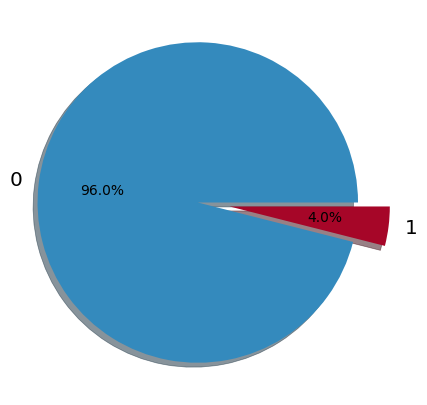

In [8]:
fig, ax = plt.subplots(figsize = (5,5))

explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. '1')

ax.pie(train_df['TARGET'].value_counts(), explode=explode, 
        labels=class_names, autopct='%1.1f%%',
        shadow=True, startangle=0)

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

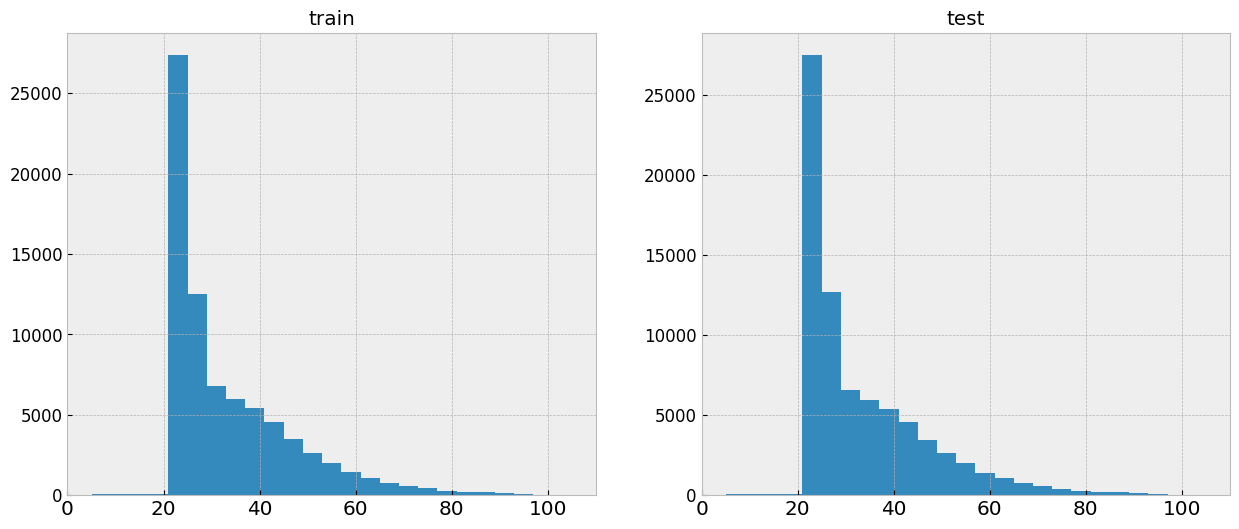

In [9]:
# var15 is AGE
fig, axes = plt.subplots(1,2)

ax = axes[0]

train_df['var15'].hist(bins=25, ax = ax)

ax.set_title('train');

ax = axes[1]

test_df['var15'].hist(bins=25, ax = ax)

ax.set_title('test');

In [10]:
# under 23 do not complain

print (len(train_df['TARGET'][train_df.var15<23]))

print (sum(train_df['TARGET'][train_df.var15<23]))

1212
0


## Feature Engineering

In [11]:
# Create another column with count of zeros
train_df['n0'] = (train_df==0).sum(axis=1)
test_df['n0'] = (test_df==0).sum(axis=1)
print (train_df.shape, test_df.shape)

(76020, 372) (75818, 371)


### Remove constant columns
One can also remove constant columns by length of unique values = 1 

In [12]:
# remove constant columns (std = 0)
drop_cols = []

for col in train_df.columns:
    
    if train_df[col].std() == 0:
        
        drop_cols.append(col)

train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

print (train_df.shape, test_df.shape)

(76020, 338) (75818, 337)


### Removal of dupe columns

In [13]:
# keep track of columns to remove
drop_cols = []

cols = train_df.columns

# loop thru cols to find equal values
for i in range(len(cols)-1):
    
    v = train_df[cols[i]].values
    
    for j in range(i+1,len(cols)):
        
        if np.array_equal(v,train_df[cols[j]].values):
            
            drop_cols.append(cols[j])


print (len(drop_cols))

29


In [14]:
## Additional columns suggested by others

# extend the list of cols to remove
drop_cols += ['num_var13_medio', 'saldo_medio_var13_medio_ult1']

In [15]:
train_df.drop(drop_cols, axis=1, inplace=True)

print (train_df.shape)

(76020, 309)


In [16]:
test_df.drop(drop_cols, axis=1, inplace=True)

print (test_df.shape)

(75818, 308)


### Log Transform

In [17]:
# log transform 'var38'
train_df['var38'] = np.log(train_df['var38'])
test_df['var38'] = np.log(test_df['var38'])

### Train, test and validation sets

In [18]:
fea_train_df = train_df.drop('TARGET', axis = 1)
y = train_df['TARGET'].to_numpy()

In [19]:
from sklearn.model_selection import train_test_split

## split into train and validation
## use X,y for full training data
X_train, X_valid, y_train, y_valid = train_test_split(fea_train_df, y, test_size=TEST_SIZE,
                                                      stratify=y, random_state=RANDOM_STATE)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(72219, 308) (72219,) (3801, 308) (3801,)


In [20]:
type(X_train), type(X_valid), type(test_df)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [21]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

X_valid = sc.transform(X_valid)

# scaling Test set also
X_test = sc.transform(test_df)

In [22]:
type(X_train), type(y_train), type(X_valid), type(y_valid), type(X_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

## Training

In [23]:
# Initialize the XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE
)

# Define an evaluation set
eval_set = [(X_train, y_train), (X_valid, y_valid)]

# Train the model with evaluation metric
model.fit(
    X_train, y_train,
    eval_metric="logloss",
    eval_set=eval_set,
    verbose=True
)

[0]	validation_0-logloss:0.19681	validation_1-logloss:0.19708


/home/pks/May2024/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.18047	validation_1-logloss:0.18104
[2]	validation_0-logloss:0.16741	validation_1-logloss:0.16831
[3]	validation_0-logloss:0.15552	validation_1-logloss:0.15654
[4]	validation_0-logloss:0.14521	validation_1-logloss:0.14619
[5]	validation_0-logloss:0.13639	validation_1-logloss:0.13736
[6]	validation_0-logloss:0.12878	validation_1-logloss:0.12977
[7]	validation_0-logloss:0.12228	validation_1-logloss:0.12324
[8]	validation_0-logloss:0.11657	validation_1-logloss:0.11763
[9]	validation_0-logloss:0.11102	validation_1-logloss:0.11211
[10]	validation_0-logloss:0.10645	validation_1-logloss:0.10746
[11]	validation_0-logloss:0.10204	validation_1-logloss:0.10307
[12]	validation_0-logloss:0.09868	validation_1-logloss:0.09983
[13]	validation_0-logloss:0.09556	validation_1-logloss:0.09669
[14]	validation_0-logloss:0.09246	validation_1-logloss:0.09366
[15]	validation_0-logloss:0.09036	validation_1-logloss:0.09180
[16]	validation_0-logloss:0.08751	validation_1-logloss:0.08888
[

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=24, ...)

In [24]:
y_pred = model.predict(X_valid)

In [25]:
print(f'Accuracy : {accuracy_score(y_valid, y_pred):.4f}')

print(f'Precision: {precision_score(y_valid, y_pred, average="macro"):.4f}')

print(f'Recall   : {recall_score(y_valid, y_pred, average="macro"):.4f}')

Accuracy : 0.9824
Precision: 0.9798
Recall   : 0.7831


In [26]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3651
           1       0.98      0.57      0.72       150

    accuracy                           0.98      3801
   macro avg       0.98      0.78      0.85      3801
weighted avg       0.98      0.98      0.98      3801



In [27]:
y_proba = model.predict_proba(X_valid)

In [28]:
## xgb, predict probabilities
print (roc_auc_score(y_valid, y_proba[:,1]))

0.9655966401899023


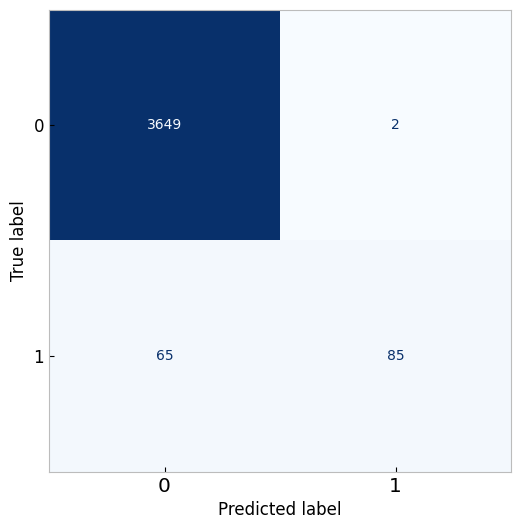

In [30]:
cm = confusion_matrix(y_valid, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                   display_labels=class_names)

disp.plot(cmap=plt.cm.Blues, colorbar=False);
plt.grid(False)

In [ ]:
### Try adjusting output of some of the parameters to zero...

# remember features that predict 0
'''zero_feats = [('saldo_medio_var5_hace2', 160000), 
              ('saldo_var33', 0),
              ('var38', 3988596),
              ('var21', 7500),
              ('num_var30', 9),
              ('num_var13_0', 6),
              ('num_var33_0', 0),
              ('imp_ent_var16_ult1', 51003),
              ('imp_op_var39_comer_ult3', 13184),
              ('saldo_medio_var5_ult3', 108251),
             ]
for x,y in zero_feats:
    print (x, train[(train[x] > y) & (train.TARGET==1)].shape)
'''
